# IPL Dataset Analysis

#### IPL data analysis using `matches.csv` and `deliveries.csv`. Includes preprocessing, cleaning, EDA (including batsman performance),feature engineering, and modeling preparation steps with markdown.

<div style="text-align:center; padding:15px; border-radius:15px; margin:20px 0;">
    <img src="https://raw.githubusercontent.com/genieincodebottle/generative-ai/main/images/ipl-image.png" 
         alt="IPL Team" 
         style="width:100%; max-width:800px; border:5px solid #000000; border-radius:10px; display:block; margin:auto; box-shadow:0 4px 8px rgba(0,0,0,0.2);">
</div>

# Setup: Install and Import Libraries

#### First, make sure all necessary libraries are installed.

# Import necessary libraries

In [2]:
# Import necessary libraries

# Plotly visualization
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
from plotly.subplots import make_subplots

# --- SET KAGGLE RENDERER ---
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "kaggle" 
print(f"Plotly default renderer set to: {pio.renderers.default}")


# Standard libraries
import warnings
from datetime import datetime

# Data manipulation libraries
import numpy as np
import pandas as pd

# Matplotlib visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot aesthetics
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

Plotly default renderer set to: kaggle


# 1. Data Ingestion/Loading
#### Load the `matches.csv` and `deliveries.csv` datasets.


In [3]:
try:
    # Load the matches and deliveries datasets
    matches_df = pd.read_csv('./matches.csv', na_values=['NA', ''])
    deliveries_df = pd.read_csv('./deliveries.csv',na_values=['NA', ''])
    
    # Print loading success message and dataset dimensions
    print("Successfully loaded matches.csv and deliveries.csv")
    print(f"Matches dataset shape: {matches_df.shape}")
    print(f"Deliveries dataset shape: {deliveries_df.shape}")
    
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please ensure 'matches.csv' and 'deliveries.csv' are in the same directory.")
    exit()  # Exit if files are not found

# Display sample data
print("\nMatches Data - First 5 rows:")
print(matches_df.head())

print("\nDeliveries Data - First 5 rows:")
print(deliveries_df.head())

Successfully loaded matches.csv and deliveries.csv
Matches dataset shape: (1095, 20)
Deliveries dataset shape: (260920, 17)

Matches Data - First 5 rows:
       id   season        city        date match_type player_of_match  \
0  335982  2007/08   Bangalore  2008-04-18     League     BB McCullum   
1  335983  2007/08  Chandigarh  2008-04-19     League      MEK Hussey   
2  335984  2007/08       Delhi  2008-04-19     League     MF Maharoof   
3  335985  2007/08      Mumbai  2008-04-20     League      MV Boucher   
4  335986  2007/08     Kolkata  2008-04-20     League       DJ Hussey   

                                        venue                        team1  \
0                       M Chinnaswamy Stadium  Royal Challengers Bangalore   
1  Punjab Cricket Association Stadium, Mohali              Kings XI Punjab   
2                            Feroz Shah Kotla             Delhi Daredevils   
3                            Wankhede Stadium               Mumbai Indians   
4                

# 2. Data Exploration
#### Examine the Structure, Types, Missing Values, and basic Statistics of both datasets.

In [4]:
print("\n---------- 2a. DATA EXPLORATION (Matches Data) ----------")

print("\nMatches Data - Column information:")
matches_df.info()

print("\nMatches Data - Summary statistics for numerical columns:")
# Need to convert result_margin to numeric first if it's not already
matches_df['result_margin'] = pd.to_numeric(matches_df['result_margin'], errors='coerce')
print(matches_df.describe())

print("\nMatches Data - Missing values per column:")
print(matches_df.isnull().sum())

print(f"\nMatches Data - Number of duplicate rows: {matches_df.duplicated().sum()}")

# --- 2b. DATA EXPLORATION (Deliveries Data) ---
print("\n---------- 2b. DATA EXPLORATION (Deliveries Data) ----------")

print("\nDeliveries Data - Column information:")
deliveries_df.info()

print("\nDeliveries Data - Summary statistics for numerical columns:")
print(deliveries_df.describe())

print("\nDeliveries Data - Missing values per column:")
# Fill categorical NAs related to dismissal with 'No Dismissal' or similar for clarity
deliveries_df['player_dismissed'] = deliveries_df['player_dismissed'].fillna('No Dismissal')
deliveries_df['dismissal_kind'] = deliveries_df['dismissal_kind'].fillna('No Dismissal')
deliveries_df['fielder'] = deliveries_df['fielder'].fillna('None')
deliveries_df['extras_type'] = deliveries_df['extras_type'].fillna('None')  # Fill NA extras type

# Re-check after filling
print(deliveries_df.isnull().sum()) 

print(f"\nDeliveries Data - Number of duplicate rows: {deliveries_df.duplicated().sum()}")
# Note: Duplicates might be possible in deliveries data if re-bowls occur, context matters.


---------- 2a. DATA EXPLORATION (Matches Data) ----------

Matches Data - Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1095 non-null   int64  
 1   season           1095 non-null   object 
 2   city             1044 non-null   object 
 3   date             1095 non-null   object 
 4   match_type       1095 non-null   object 
 5   player_of_match  1090 non-null   object 
 6   venue            1095 non-null   object 
 7   team1            1095 non-null   object 
 8   team2            1095 non-null   object 
 9   toss_winner      1095 non-null   object 
 10  toss_decision    1095 non-null   object 
 11  winner           1090 non-null   object 
 12  result           1095 non-null   object 
 13  result_margin    1076 non-null   float64
 14  target_runs      1092 non-null   float64
 15  target_over

# 3. Data Cleaning
#### Handle missing values, correct data types, standardize names, and manage potential outliers.

In [5]:
print("\n---------- 3. DATA CLEANING (Matches Data) ----------")

# 3.1 Handle missing values
print("\n3.1 Handling missing values (Matches)")
# First, make a copy to preserve the original data
matches_clean = matches_df.copy()

# Handle missing winner, result, result_margin, player_of_match based on context
# If 'result' is 'tie' or 'no result', winner might be NaN legitimately.
# Fill 'winner' and 'player_of_match' for 'no result' matches
no_result_indices = matches_clean[matches_clean['result'] == 'no result'].index
matches_clean.loc[no_result_indices, 'winner'] = matches_clean.loc[no_result_indices, 'winner'].fillna('No Result')
matches_clean.loc[no_result_indices, 'player_of_match'] = matches_clean.loc[no_result_indices, 'player_of_match'].fillna('Not Awarded')

# Fill remaining NaNs in winner/player_of_match where a result exists (might indicate data entry issue)
# For simplicity, filling with 'Unknown' or 'Not Awarded'
matches_clean['winner'] = matches_clean['winner'].fillna('Unknown')
matches_clean['player_of_match'] = matches_clean['player_of_match'].fillna('Not Awarded')

# Fill missing city with 'Unknown'
matches_clean['city'] = matches_clean['city'].fillna('Unknown')

# Fill missing result_margin with 0 (assuming 0 margin if NaN)
matches_clean['result_margin'] = matches_clean['result_margin'].fillna(0)

# Handle method (like DL) - Fill NaN method with 'Normal'
matches_clean['method'] = matches_clean['method'].fillna('Normal')

# Fill missing umpires with 'Unknown'
matches_clean['umpire1'] = matches_clean['umpire1'].fillna('Unknown')
matches_clean['umpire2'] = matches_clean['umpire2'].fillna('Unknown')

# Derive win_by_runs and win_by_wickets from result and result_margin
matches_clean['win_by_runs'] = np.where(
    matches_clean['result'] == 'runs', 
    matches_clean['result_margin'], 
    0
).astype(int)

matches_clean['win_by_wickets'] = np.where(
    matches_clean['result'] == 'wickets', 
    matches_clean['result_margin'], 
    0
).astype(int)

# Check remaining missing values
print("\nRemaining missing values after cleaning (Matches):")
print(matches_clean.isnull().sum())


# 3.2 Fix data types (Matches)
print("\n3.2 Fixing data types (Matches)")
# Convert date to datetime
matches_clean['date'] = pd.to_datetime(matches_clean['date'], format='%Y-%m-%d')

# Extract date components
matches_clean['year'] = matches_clean['date'].dt.year
matches_clean['month'] = matches_clean['date'].dt.month
matches_clean['day'] = matches_clean['date'].dt.day
matches_clean['day_of_week'] = matches_clean['date'].dt.dayofweek  # Monday=0, Sunday=6
matches_clean['is_weekend'] = matches_clean['day_of_week'].isin([5, 6]).astype(int)  # 5=Saturday, 6=Sunday

# Convert season to starting year
matches_clean['season_year'] = matches_clean['season'].astype(str).str.split('/').str[0].astype(int)

# Convert boolean-like columns
matches_clean['super_over'] = matches_clean['super_over'].map({'Y': 1, 'N': 0}).fillna(0).astype(int)
# Add a DL applied column based on method
matches_clean['dl_applied'] = np.where(matches_clean['method'] == 'D/L', 1, 0).astype(int)

print("\nMatches Data types after conversion:")
print(matches_clean.dtypes[['date', 'year', 'month', 'day', 'day_of_week', 
                            'is_weekend', 'season_year', 'super_over', 
                            'dl_applied', 'win_by_runs', 'win_by_wickets']])


# 3.3 Check and fix inconsistencies (Matches)
print("\n3.3 Checking and fixing inconsistencies (Matches)")
print("\nUnique team names in team1:")
print(sorted(matches_clean['team1'].unique()))

# Example of fixing inconsistencies (apply based on unique names list)
team_name_mapping = {
    'Rising Pune Supergiants': 'Rising Pune Supergiant',  # Example
    # Add more mappings if needed after inspecting unique names
}

# Apply team name corrections to all relevant columns
matches_clean['team1'] = matches_clean['team1'].replace(team_name_mapping)
matches_clean['team2'] = matches_clean['team2'].replace(team_name_mapping)
matches_clean['toss_winner'] = matches_clean['toss_winner'].replace(team_name_mapping)
matches_clean['winner'] = matches_clean['winner'].replace(team_name_mapping)

# Update batting/bowling teams in deliveries_df too
deliveries_df['batting_team'] = deliveries_df['batting_team'].replace(team_name_mapping)
deliveries_df['bowling_team'] = deliveries_df['bowling_team'].replace(team_name_mapping)


# 3.4 Handling outliers (Matches)
print("\n3.4 Handling outliers (Matches)")

# Create boxplots for derived win_by_runs and win_by_wickets
fig = go.Figure()
fig.add_trace(go.Box(
    y=matches_clean[matches_clean['win_by_runs'] > 0]['win_by_runs'],  # Filter 0 values
    name='Wins by Runs', 
    boxmean=True, 
    marker_color='blue'
))
fig.add_trace(go.Box(
    y=matches_clean[matches_clean['win_by_wickets'] > 0]['win_by_wickets'],  # Filter 0 values
    name='Wins by Wickets', 
    boxmean=True, 
    marker_color='green'
))
fig.update_layout(
    title='Distribution of Win Margins (Excluding Zero)',
    yaxis_title='Margin Value', 
    boxmode='group'
)
fig.show()
print("No outlier removal needed as extreme values are valid cricket match outcomes.")


# 3.5 Data Cleaning (Deliveries)
print("\n3.5 Data Cleaning (Deliveries)")
# Convert relevant columns to numeric, coercing errors
num_cols_del = ['batsman_runs', 'extra_runs', 'total_runs', 'is_wicket']
for col in num_cols_del:
    deliveries_df[col] = pd.to_numeric(deliveries_df[col], errors='coerce').fillna(0)

# Ensure IDs are consistent types if merging later
matches_clean['id'] = matches_clean['id'].astype(int)
deliveries_df['match_id'] = deliveries_df['match_id'].astype(int)

print("Deliveries data types checked/converted.")
print(deliveries_df[num_cols_del + ['match_id']].dtypes)


---------- 3. DATA CLEANING (Matches Data) ----------

3.1 Handling missing values (Matches)

Remaining missing values after cleaning (Matches):
id                 0
season             0
city               0
date               0
match_type         0
player_of_match    0
venue              0
team1              0
team2              0
toss_winner        0
toss_decision      0
winner             0
result             0
result_margin      0
target_runs        3
target_overs       3
super_over         0
method             0
umpire1            0
umpire2            0
win_by_runs        0
win_by_wickets     0
dtype: int64

3.2 Fixing data types (Matches)

Matches Data types after conversion:
date              datetime64[ns]
year                       int32
month                      int32
day                        int32
day_of_week                int32
is_weekend                 int32
season_year                int32
super_over                 int32
dl_applied                 int32
win_by_runs

No outlier removal needed as extreme values are valid cricket match outcomes.

3.5 Data Cleaning (Deliveries)
Deliveries data types checked/converted.
batsman_runs    int64
extra_runs      int64
total_runs      int64
is_wicket       int64
match_id        int32
dtype: object


# 4. Exploratory Data Analysis (EDA)
#### Visualize patterns and trends in the data.

In [6]:
print("\n---------- 4. EXPLORATORY DATA ANALYSIS (Matches) ----------")

# 4.1 Distribution of matches across seasons
print("\n4.1 Distribution of matches across seasons")
season_counts = matches_clean['season_year'].value_counts().sort_index()
print(season_counts)
fig1 = px.bar(x=season_counts.index, y=season_counts.values,
              title='Number of IPL Matches per Season',
              labels={'x': 'Season Year', 'y': 'Number of Matches'})
fig1.update_layout(xaxis_tickangle=-45)
fig1.show()

# 4.2 Most successful teams
print("\n4.2 Most successful teams")
# Exclude 'No Result' and 'Unknown' winners
team_wins = matches_clean[~matches_clean['winner'].isin(['No Result', 'Unknown'])]['winner'].value_counts()
print(team_wins.head(10))
top_teams = team_wins.head(10).sort_values(ascending=True)
fig2 = px.bar(x=top_teams.values, y=top_teams.index, orientation='h',
              title='Top 10 Teams with Most Wins in IPL',
              labels={'x': 'Number of Wins', 'y': 'Team'})
fig2.show()

# 4.3 Toss decision analysis
print("\n4.3 Toss decision analysis")
toss_decisions = matches_clean['toss_decision'].value_counts()
print(toss_decisions)
fig3 = px.pie(values=toss_decisions.values, names=toss_decisions.index,
              title='Toss Decisions in IPL')
fig3.update_traces(textposition='inside', textinfo='percent+label')
fig3.show()

# 4.4 Impact of toss on match result
print("\n4.4 Impact of toss on match result")
matches_clean['toss_winner_won_match'] = (matches_clean['toss_winner'] == matches_clean['winner']).astype(int)
# Exclude matches with no result or unknown winner for calculating meaningful percentage
valid_matches_for_toss_impact = matches_clean[~matches_clean['winner'].isin(['No Result', 'Unknown'])]
toss_win_percentage = valid_matches_for_toss_impact['toss_winner_won_match'].mean() * 100
print(f"Percentage of matches (with result) where toss winner also won: {toss_win_percentage:.2f}%")

toss_decision_impact = valid_matches_for_toss_impact.groupby('toss_decision')['toss_winner_won_match'].mean() * 100
print("\nWin percentage when winning toss & choosing to bat vs field:")
print(toss_decision_impact)
fig4 = px.bar(x=toss_decision_impact.index, y=toss_decision_impact.values,
              title='Match Win % When Winning Toss (by Decision)',
              labels={'x': 'Toss Decision', 'y': 'Win Percentage'})
fig4.update_layout(yaxis_range=[0, 100])
fig4.show()

# 4.5 Venue analysis
print("\n4.5 Venue analysis")
venue_counts = matches_clean['venue'].value_counts().head(10)
print("Top 10 venues by number of matches:")
print(venue_counts)
fig5 = px.bar(x=venue_counts.values, y=venue_counts.index, orientation='h',
              title='Top 10 IPL Venues by Number of Matches',
              labels={'x': 'Number of Matches', 'y': 'Venue'})
fig5.update_xaxes(title_text="Number of Matches")
fig5.update_yaxes(title_text="Venue")
fig5.show()


# 4.6 Player of the match analysis
print("\n4.6 Player of the match analysis")
player_of_match_counts = matches_clean[matches_clean['player_of_match'] != 'Not Awarded']['player_of_match'].value_counts().head(10)
print("Top 10 players with most Player of the Match awards:")
print(player_of_match_counts)
fig6 = px.bar(x=player_of_match_counts.values, y=player_of_match_counts.index, orientation='h',
              title='Top 10 Players with Most Player of the Match Awards',
              labels={'x': 'Number of Awards', 'y': 'Player'})
fig6.update_xaxes(title_text="Number of Awards")
fig6.update_yaxes(title_text="Player")
fig6.show()

# 4.7 Win margin analysis
print("\n4.7 Win margin analysis")
# Distribution of win by runs (excluding 0)
fig7 = px.histogram(matches_clean[matches_clean['win_by_runs'] > 0], x='win_by_runs', nbins=20,
                    title='Distribution of Victory Margin (Runs)')
fig7.update_layout(xaxis_title='Runs', yaxis_title='Frequency')
fig7.show()

# Distribution of win by wickets (excluding 0)
fig8 = px.histogram(matches_clean[matches_clean['win_by_wickets'] > 0], x='win_by_wickets', nbins=10,
                    title='Distribution of Victory Margin (Wickets)')
fig8.update_layout(xaxis_title='Wickets', yaxis_title='Frequency')
fig8.show()

# 4.8 Match outcomes over time (trend analysis)
print("\n4.8 Match outcomes over time")
runs_by_season = matches_clean.groupby('season_year')['win_by_runs'].mean()
wickets_by_season = matches_clean.groupby('season_year')['win_by_wickets'].mean()

fig9 = px.line(x=runs_by_season.index, y=runs_by_season.values, markers=True,
               title='Average Win Margin (Runs) by Season')
fig9.update_layout(xaxis_title='Season Year', yaxis_title='Average Runs')
fig9.show()

fig10 = px.line(x=wickets_by_season.index, y=wickets_by_season.values, markers=True,
                title='Average Win Margin (Wickets) by Season')
fig10.update_layout(xaxis_title='Season Year', yaxis_title='Average Wickets')
fig10.show()


# --- 4b. EXPLORATORY DATA ANALYSIS (EDA) - Deliveries (Batsman Performance) ---
print("\n---------- 4b. EXPLORATORY DATA ANALYSIS (Deliveries - Batsman) ----------")

# Merge deliveries with matches to get season context
deliveries_merged = pd.merge(deliveries_df, matches_clean[['id', 'season_year']], left_on='match_id', right_on='id', how='left')

# 4b.1 Top Run Scorers (Overall)
print("\n4b.1 Top Run Scorers (Overall)")
batsman_runs = deliveries_merged.groupby('batter')['batsman_runs'].sum().sort_values(ascending=False)
print(batsman_runs.head(10))

# Visualize Top 10 Run Scorers
top_10_scorers = batsman_runs.head(10)
fig11 = px.bar(x=top_10_scorers.index, y=top_10_scorers.values,
               title='Top 10 Run Scorers in IPL History',
               labels={'x': 'Batsman', 'y': 'Total Runs'})
fig11.show()

# 4b.2 Batsman Strike Rates (Overall, min 500 balls faced)
print("\n4b.2 Batsman Strike Rates (Overall, min 500 balls faced)")
# Exclude wides for balls faced count, but include no-balls, legbyes etc. as faced balls
balls_faced = deliveries_merged[deliveries_merged['extras_type'] != 'wides'].groupby('batter')['ball'].count()
batsman_strike_rate = (batsman_runs / balls_faced * 100)

# Filter for batsmen with minimum balls faced
min_balls_threshold = 500
batsman_sr_filtered = batsman_strike_rate[balls_faced >= min_balls_threshold].sort_values(ascending=False)
print(batsman_sr_filtered.head(10))

# Visualize Top 10 Strike Rates
top_10_sr = batsman_sr_filtered.head(10)
fig12 = px.bar(x=top_10_sr.index, y=top_10_sr.values,
               title=f'Top 10 Batsman Strike Rates (Min {min_balls_threshold} Balls Faced)',
               labels={'x': 'Batsman', 'y': 'Strike Rate'})
fig12.show()

# 4b.3 Batsman Averages (Overall, min 20 dismissals)
print("\n4b.3 Batsman Averages (Overall, min 20 dismissals)")
dismissals = deliveries_merged[deliveries_merged['is_wicket'] == 1]['player_dismissed'].value_counts()
# Ensure dismissals index matches batsman_runs index (handle potential name mismatches if any)
dismissals = dismissals.reindex(batsman_runs.index, fill_value=0)

batsman_average = batsman_runs / dismissals
# Handle cases where batsman was never dismissed (average is infinity) -> replace with total runs or NaN
batsman_average.replace([np.inf, -np.inf], np.nan, inplace=True) # Or fillna(batsman_runs)

min_dismissals_threshold = 20
batsman_avg_filtered = batsman_average[dismissals >= min_dismissals_threshold].sort_values(ascending=False)
print(batsman_avg_filtered.head(10))

# Visualize Top 10 Averages
top_10_avg = batsman_avg_filtered.head(10)
fig13 = px.bar(x=top_10_avg.index, y=top_10_avg.values,
               title=f'Top 10 Batsman Averages (Min {min_dismissals_threshold} Dismissals)',
               labels={'x': 'Batsman', 'y': 'Average Runs'})
fig13.show()

# 4b.4 Most Sixes (Overall)
print("\n4b.4 Most Sixes (Overall)")
sixes = deliveries_merged[deliveries_merged['batsman_runs'] == 6].groupby('batter')['batsman_runs'].count().sort_values(ascending=False)
print(sixes.head(10))

# Visualize Top 10 Six Hitters
top_10_sixes = sixes.head(10)
fig14 = px.bar(x=top_10_sixes.index, y=top_10_sixes.values,
               title='Top 10 Batsmen by Number of Sixes Hit',
               labels={'x': 'Batsman', 'y': 'Number of Sixes'})
fig14.show()

# 4b.5 Top Run Scorers per Season
print("\n4b.5 Top Run Scorers per Season")
runs_per_season = deliveries_merged.groupby(['season_year', 'batter'])['batsman_runs'].sum().reset_index()
# Find the top scorer for each season
top_scorer_per_season = runs_per_season.loc[runs_per_season.groupby('season_year')['batsman_runs'].idxmax()]
print(top_scorer_per_season.sort_values('season_year'))

fig15 = px.bar(top_scorer_per_season.sort_values('season_year'), x='season_year', y='batsman_runs', color='batter',
               title='Top Run Scorer (Orange Cap) Each Season',
               labels={'season_year': 'Season', 'batsman_runs': 'Total Runs', 'batter': 'Batsman'})
fig15.update_layout(xaxis={'type': 'category'}) # Treat season year as category
fig15.show()


---------- 4. EXPLORATORY DATA ANALYSIS (Matches) ----------

4.1 Distribution of matches across seasons
season_year
2007     58
2009    117
2011     73
2012     74
2013     76
2014     60
2015     59
2016     60
2017     59
2018     60
2019     60
2020     60
2021     60
2022     74
2023     74
2024     71
Name: count, dtype: int64



4.2 Most successful teams
winner
Mumbai Indians                 144
Chennai Super Kings            138
Kolkata Knight Riders          131
Royal Challengers Bangalore    116
Rajasthan Royals               112
Kings XI Punjab                 88
Sunrisers Hyderabad             88
Delhi Daredevils                67
Delhi Capitals                  48
Deccan Chargers                 29
Name: count, dtype: int64



4.3 Toss decision analysis
toss_decision
field    704
bat      391
Name: count, dtype: int64



4.4 Impact of toss on match result
Percentage of matches (with result) where toss winner also won: 50.83%

Win percentage when winning toss & choosing to bat vs field:
toss_decision
bat      45.384615
field    53.857143
Name: toss_winner_won_match, dtype: float64



4.5 Venue analysis
Top 10 venues by number of matches:
venue
Eden Gardens                                  77
Wankhede Stadium                              73
M Chinnaswamy Stadium                         65
Feroz Shah Kotla                              60
Rajiv Gandhi International Stadium, Uppal     49
MA Chidambaram Stadium, Chepauk               48
Sawai Mansingh Stadium                        47
Dubai International Cricket Stadium           46
Wankhede Stadium, Mumbai                      45
Punjab Cricket Association Stadium, Mohali    35
Name: count, dtype: int64



4.6 Player of the match analysis
Top 10 players with most Player of the Match awards:
player_of_match
AB de Villiers    25
CH Gayle          22
RG Sharma         19
DA Warner         18
V Kohli           18
MS Dhoni          17
SR Watson         16
YK Pathan         16
RA Jadeja         16
AD Russell        15
Name: count, dtype: int64



4.7 Win margin analysis



4.8 Match outcomes over time



---------- 4b. EXPLORATORY DATA ANALYSIS (Deliveries - Batsman) ----------

4b.1 Top Run Scorers (Overall)
batter
V Kohli           8014
S Dhawan          6769
RG Sharma         6630
DA Warner         6567
SK Raina          5536
MS Dhoni          5243
AB de Villiers    5181
CH Gayle          4997
RV Uthappa        4954
KD Karthik        4843
Name: batsman_runs, dtype: int64



4b.2 Batsman Strike Rates (Overall, min 500 balls faced)
batter
AD Russell         174.841883
H Klaasen          168.305085
SP Narine          165.837838
LS Livingstone     162.456747
N Pooran           161.996337
RM Patidar         158.846918
GJ Maxwell         156.698700
V Sehwag           155.441595
Abhishek Sharma    155.242390
SO Hetmyer         153.078818
dtype: float64



4b.3 Batsman Averages (Overall, min 20 dismissals)
batter
B Sai Sudharsan    47.000000
KL Rahul           44.657143
RD Gaikwad         41.754386
DA Warner          40.042683
LMP Simmons        39.962963
Tilak Varma        39.862069
AB de Villiers     39.853846
JP Duminy          39.784314
CH Gayle           39.658730
SE Marsh           39.507937
dtype: float64



4b.4 Most Sixes (Overall)
batter
CH Gayle          359
RG Sharma         281
V Kohli           273
AB de Villiers    253
MS Dhoni          252
DA Warner         236
KA Pollard        224
AD Russell        209
SV Samson         206
SK Raina          204
Name: batsman_runs, dtype: int64



4b.5 Top Run Scorers per Season
      season_year         batter  batsman_runs
115          2007       SE Marsh           616
335          2009   SR Tendulkar           982
400          2011       CH Gayle           608
582          2012       CH Gayle           733
808          2013     MEK Hussey           733
986          2014     RV Uthappa           660
1046         2015      DA Warner           562
1281         2016        V Kohli           973
1320         2017      DA Warner           641
1492         2018  KS Williamson           735
1592         2019      DA Warner           692
1764         2020       KL Rahul           676
1949         2021     RD Gaikwad           635
2042         2022     JC Buttler           863
2321         2023   Shubman Gill           890
2504         2024        V Kohli           741


# 5. Feature Engineering
#### Create new features from existing data to potentially improve model performance or gain deeper insights.

In [7]:
print("\n---------- 5. FEATURE ENGINEERING (Matches Data) ----------")

# 5.1 Team matchups
print("\n5.1 Team matchups")
matches_clean['matchup'] = matches_clean.apply(
    lambda row: f"{sorted([row['team1'], row['team2']])[0]} vs {sorted([row['team1'], row['team2']])[1]}", axis=1
)
matchup_counts = matches_clean['matchup'].value_counts().head(10)
print("Top 10 most frequent team matchups:")
print(matchup_counts)

# 5.2 Team performance metrics (Win Rate)
print("\n5.2 Team performance metrics (Win Rate)")
# Consider only matches with a definitive winner
valid_matches = matches_clean[~matches_clean['winner'].isin(['No Result', 'Unknown'])]
team_matches_played = pd.concat([valid_matches['team1'], valid_matches['team2']]).value_counts()
team_wins = valid_matches['winner'].value_counts()
team_win_rate = (team_wins / team_matches_played).fillna(0).sort_values(ascending=False)
print("Win rate for each team (in matches with a result):")
print(team_win_rate)

# Visualize Win Rates
fig_win_rate = px.bar(x=team_win_rate.index, y=team_win_rate.values,
                      title='Overall Team Win Rates (in Matches with Result)',
                      labels={'x': 'Team', 'y': 'Win Rate'})
fig_win_rate.update_layout(yaxis_tickformat=".1%")
fig_win_rate.show()

# 5.3 Venue-based features (Win rate by venue for each team)
print("\n5.3 Venue-based features (Win rate by venue)")
team_venue_combinations = []
# Ensure we iterate over teams present in the cleaned data
teams_in_data = pd.concat([matches_clean['team1'], matches_clean['team2']]).unique()
venues_in_data = matches_clean['venue'].unique()

for team in teams_in_data:
    if team is None or pd.isna(team): continue # Skip potential None values
    for venue in venues_in_data:
        if venue is None or pd.isna(venue): continue # Skip potential None values

        # Find matches where the team played at the venue
        team_matches_at_venue = matches_clean[((matches_clean['team1'] == team) | (matches_clean['team2'] == team)) & (matches_clean['venue'] == venue)]
        matches_count = len(team_matches_at_venue)

        if matches_count > 0:
            # Find wins for the team at that venue
            team_wins_at_venue = team_matches_at_venue[team_matches_at_venue['winner'] == team]
            wins_count = len(team_wins_at_venue)
            win_rate = wins_count / matches_count
            team_venue_combinations.append({
                'team': team, 'venue': venue, 'matches': matches_count,
                'wins': wins_count, 'win_rate': win_rate
            })

venue_performance = pd.DataFrame(team_venue_combinations)
venue_performance = venue_performance.sort_values(['win_rate', 'matches'], ascending=[False, False])

print("Top 10 team-venue combinations by win rate (min 5 matches):")
print(venue_performance[venue_performance['matches'] >= 5].head(10))


# 5.4 Home advantage (Simplified)
print("\n5.4 Home advantage")
# Using approximate city-team mapping (can be refined)
team_home_city = {
    'Mumbai Indians': 'Mumbai', 'Chennai Super Kings': 'Chennai',
    'Kolkata Knight Riders': 'Kolkata', 'Royal Challengers Bangalore': 'Bangalore',
    'Delhi Daredevils': 'Delhi', 'Delhi Capitals': 'Delhi', # Added Delhi Capitals
    'Kings XI Punjab': 'Chandigarh', # Mohali is often listed as Chandigarh
    'Punjab Kings': 'Chandigarh', # Added Punjab Kings
    'Rajasthan Royals': 'Jaipur', 'Sunrisers Hyderabad': 'Hyderabad',
    'Deccan Chargers': 'Hyderabad', # Added Deccan Chargers
    'Pune Warriors': 'Pune', 'Rising Pune Supergiant': 'Pune',
    'Gujarat Lions': 'Rajkot' # Main home ground
}

matches_clean['is_team1_home'] = matches_clean.apply(
    lambda row: 1 if team_home_city.get(row['team1']) == row['city'] else 0, axis=1)
matches_clean['is_team2_home'] = matches_clean.apply(
    lambda row: 1 if team_home_city.get(row['team2']) == row['city'] else 0, axis=1)

# Analyze impact of home advantage
home_advantage_stats = []
for team in team_matches_played.index:
    # Team playing as Team 1 at home
    t1_home_matches = matches_clean[(matches_clean['team1'] == team) & (matches_clean['is_team1_home'] == 1)]
    t1_home_wins = t1_home_matches[t1_home_matches['winner'] == team]

    # Team playing as Team 2 at home
    t2_home_matches = matches_clean[(matches_clean['team2'] == team) & (matches_clean['is_team2_home'] == 1)]
    t2_home_wins = t2_home_matches[t2_home_matches['winner'] == team]

    total_home_matches = len(t1_home_matches) + len(t2_home_matches)
    total_home_wins = len(t1_home_wins) + len(t2_home_wins)

    if total_home_matches > 0:
        home_win_rate = total_home_wins / total_home_matches
        home_advantage_stats.append({'team': team, 'home_matches': total_home_matches, 'home_win_rate': home_win_rate})

home_adv_df = pd.DataFrame(home_advantage_stats).sort_values('home_win_rate', ascending=False)
print("\nHome Win Rate by Team (Simplified):")
print(home_adv_df[home_adv_df['home_matches'] >= 5]) # Min 5 home matches


# 5.5 Momentum/Form Features (Using Matches Data - Simplified)
print("\n5.5 Momentum and form features (Matches - Simplified)")
# Sort data by date
matches_clean = matches_clean.sort_values('date')

def get_recent_form(team, match_date, df, n_matches=5):
    """Calculate team's win rate in last n matches before given date"""
    previous_matches = df[
        ((df['team1'] == team) | (df['team2'] == team)) &
        (df['date'] < match_date)
    ].sort_values('date', ascending=False).head(n_matches)

    if len(previous_matches) == 0:
        return 0.5 # Default form if no previous matches

    wins = sum(previous_matches['winner'] == team)
    # Exclude no results from calculation base if needed
    valid_prev_matches = previous_matches[~previous_matches['winner'].isin(['No Result', 'Unknown'])]
    if len(valid_prev_matches) == 0:
        return 0.5 # Default if no valid previous results
    return wins / len(valid_prev_matches)

# Apply form calculation (can be slow on full dataset)
matches_clean['team1_form'] = matches_clean.apply(lambda row: get_recent_form(row['team1'], row['date'], matches_clean), axis=1)
matches_clean['team2_form'] = matches_clean.apply(lambda row: get_recent_form(row['team2'], row['date'], matches_clean), axis=1)


# 5.6 Seasonal Phase Features
print("\n5.6 Seasonal features")
season_dates = matches_clean.groupby('season_year')['date'].agg(['min', 'max'])

def get_match_phase(row, season_dates_lookup):
    if row['season_year'] not in season_dates_lookup.index:
        return 'Unknown' # Handle cases where season might be missing in lookup
    season_start = season_dates_lookup.loc[row['season_year'], 'min']
    season_end = season_dates_lookup.loc[row['season_year'], 'max']
    season_duration = (season_end - season_start).days

    if season_duration <= 0: return 'Start' # Handle single-day seasons or issues

    days_from_start = (row['date'] - season_start).days
    position_in_season = days_from_start / season_duration

    if position_in_season < 0.33: return 'Start'
    elif position_in_season < 0.67: return 'Middle'
    else: return 'End'

matches_clean['season_phase'] = matches_clean.apply(lambda row: get_match_phase(row, season_dates), axis=1)

# Analyze toss win impact by season phase
season_phase_stats = valid_matches_for_toss_impact.groupby(matches_clean['season_phase'])['toss_winner_won_match'].mean() * 100
print("Impact of winning toss on match outcome by season phase:")
print(season_phase_stats)


---------- 5. FEATURE ENGINEERING (Matches Data) ----------

5.1 Team matchups
Top 10 most frequent team matchups:
matchup
Chennai Super Kings vs Mumbai Indians                   37
Kolkata Knight Riders vs Mumbai Indians                 34
Kolkata Knight Riders vs Royal Challengers Bangalore    32
Mumbai Indians vs Royal Challengers Bangalore           32
Chennai Super Kings vs Royal Challengers Bangalore      30
Rajasthan Royals vs Royal Challengers Bangalore         29
Chennai Super Kings vs Rajasthan Royals                 29
Mumbai Indians vs Rajasthan Royals                      29
Chennai Super Kings vs Kolkata Knight Riders            29
Kolkata Knight Riders vs Rajasthan Royals               28
Name: count, dtype: int64

5.2 Team performance metrics (Win Rate)
Win rate for each team (in matches with a result):
Gujarat Titans                 0.622222
Chennai Super Kings            0.582278
Lucknow Super Giants           0.558140
Mumbai Indians                 0.551724
Delhi Ca


5.3 Venue-based features (Win rate by venue)
Top 10 team-venue combinations by win rate (min 5 matches):
                    team                                         venue  \
289  Chennai Super Kings                              Feroz Shah Kotla   
312  Chennai Super Kings       Maharashtra Cricket Association Stadium   
78       Kings XI Punjab  Punjab Cricket Association IS Bindra Stadium   
117       Mumbai Indians                         M Chinnaswamy Stadium   
73       Kings XI Punjab                       Sharjah Cricket Stadium   
433       Delhi Capitals              Narendra Modi Stadium, Ahmedabad   
321  Chennai Super Kings                        MA Chidambaram Stadium   
121       Mumbai Indians                                  Eden Gardens   
240     Rajasthan Royals                          Sheikh Zayed Stadium   
383  Sunrisers Hyderabad            Rajiv Gandhi International Stadium   

     matches  wins  win_rate  
289        6     5  0.833333  
312        6     

# 6. Preparing Data for Modeling
#### Select features, encode categorical variables, scale numerical data, and split into training and testing sets.


In [8]:
print("\n---------- 6. PREPARING DATA FOR MODELING ----------")

# 6.1 One-hot encoding for categorical variables
print("\n6.1 One-hot encoding")
# Select features for modeling (example subset)
features_for_model = ['season_year', 'win_by_runs', 'win_by_wickets', 'dl_applied', 'super_over',
                      'is_weekend', 'toss_winner_won_match', 'is_team1_home', 'is_team2_home',
                      'team1', 'team2', 'toss_winner', 'toss_decision', 'city', 'venue', 'season_phase']
model_df = matches_clean[features_for_model].copy()

# Handle potential remaining NaNs before encoding (should be minimal after cleaning)
model_df.dropna(subset=['team1', 'team2', 'toss_winner', 'venue', 'city', 'toss_decision'], inplace=True) # Drop rows where key categoricals are missing

cat_columns = ['team1', 'team2', 'toss_winner', 'toss_decision', 'city', 'venue', 'season_phase']
model_df_encoded = pd.get_dummies(model_df, columns=cat_columns, drop_first=True, dummy_na=False) # dummy_na=False explicit

print(f"Shape after one-hot encoding: {model_df_encoded.shape}")
print(f"Number of features: {model_df_encoded.shape[1]}")

# 6.2 Feature scaling
print("\n6.2 Feature scaling")
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Identify numerical columns to scale (excluding binary/encoded ones)
numerical_cols = ['season_year', 'win_by_runs', 'win_by_wickets'] # Add other relevant numerical features if used
cols_to_scale = [col for col in numerical_cols if col in model_df_encoded.columns]

if cols_to_scale:
    model_df_encoded[cols_to_scale] = scaler.fit_transform(model_df_encoded[cols_to_scale])
    print("Sample of scaled features:")
    print(model_df_encoded[cols_to_scale].head())
else:
    print("No numerical columns found to scale.")


# 6.3 Train-test split
print("\n6.3 Train-test split")
from sklearn.model_selection import train_test_split

# Example: Predicting if team1 wins
# Define target variable (ensure alignment after potential row drops)
# Target: 1 if team1 wins, 0 otherwise (team2 wins or no result/tie handled by winner column)
# Re-align target 'y' with the potentially filtered model_df_encoded index
target_series = (matches_clean.loc[model_df_encoded.index, 'winner'] == matches_clean.loc[model_df_encoded.index, 'team1']).astype(int)

X = model_df_encoded.drop(columns=['toss_winner_won_match']) # Assuming toss_winner_won_match is not used as direct feature
y = target_series

if len(X) == len(y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) # Stratify for classification
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
else:
    print(f"Error: Mismatch between feature count ({len(X)}) and target count ({len(y)}). Skipping train-test split.")



---------- 6. PREPARING DATA FOR MODELING ----------

6.1 One-hot encoding
Shape after one-hot encoding: (1095, 156)
Number of features: 156

6.2 Feature scaling
Sample of scaled features:
   season_year  win_by_runs  win_by_wickets
0    -1.765973     5.389492       -0.970142
1    -1.765973     0.823886       -0.970142
2    -1.765973    -0.584198        1.701205
3    -1.765973    -0.584198        0.513940
4    -1.765973    -0.584198        0.513940

6.3 Train-test split
Training set shape: (821, 155)
Test set shape: (274, 155)


# 7. Advanced Feature Engineering (Optional)
#### Explore more complex features like Elo ratings or interaction terms.

In [9]:
print("\n---------- 7. ADVANCED FEATURE ENGINEERING ----------")

# 7.1 Team strength index (Elo-like) - Re-run based on cleaned matches
print("\n7.1 Team strength index (Elo-like)")
team_ratings = {team: 1500 for team in pd.concat([matches_clean['team1'], matches_clean['team2']]).dropna().unique()}
K = 32

def update_ratings(winner, loser, ratings, k=K):
    if winner not in ratings or loser not in ratings: return # Skip if team not initialized
    expected_winner = 1 / (1 + 10 ** ((ratings[loser] - ratings[winner]) / 400))
    expected_loser = 1 / (1 + 10 ** ((ratings[winner] - ratings[loser]) / 400))
    ratings[winner] += k * (1 - expected_winner)
    ratings[loser] += k * (0 - expected_loser)

# Iterate through sorted matches to update ratings chronologically
temp_ratings = team_ratings.copy()
match_ratings = [] # Store ratings *before* each match
for idx, row in matches_clean.sort_values('date').iterrows():
     # Store ratings *before* this match happens
    match_ratings.append({
        'match_id': row['id'],
        f"{row['team1']}_rating": temp_ratings.get(row['team1'], 1500),
        f"{row['team2']}_rating": temp_ratings.get(row['team2'], 1500)
    })
    # Update ratings after the match
    if row['winner'] not in ['No Result', 'Unknown', None] and pd.notna(row['winner']):
        if row['winner'] == row['team1']:
            update_ratings(row['team1'], row['team2'], temp_ratings)
        elif row['winner'] == row['team2']:
             update_ratings(row['team2'], row['team1'], temp_ratings)

final_team_ratings = temp_ratings
sorted_ratings = sorted(final_team_ratings.items(), key=lambda x: x[1], reverse=True)
print("Final Team ratings:")
for team, rating in sorted_ratings:
    print(f"{team}: {rating:.2f}")


# 7.2 Interaction features
print("\n7.2 Interaction features")
# Example: Toss decision * toss winner is home team
matches_clean['toss_winner_is_home'] = np.where(
    matches_clean['toss_winner'] == matches_clean['team1'], matches_clean['is_team1_home'],
    np.where(matches_clean['toss_winner'] == matches_clean['team2'], matches_clean['is_team2_home'], 0)
)
matches_clean['toss_field_home_win'] = (matches_clean['toss_decision'] == 'field') & (matches_clean['toss_winner_is_home'] == 1) & (matches_clean['toss_winner_won_match'] == 1)
matches_clean['toss_bat_home_win'] = (matches_clean['toss_decision'] == 'bat') & (matches_clean['toss_winner_is_home'] == 1) & (matches_clean['toss_winner_won_match'] == 1)
print(f"Prob win | Field, Home, Won Toss: {matches_clean['toss_field_home_win'].mean():.3f}")
print(f"Prob win | Bat, Home, Won Toss: {matches_clean['toss_bat_home_win'].mean():.3f}")

# 7.3 Team rivalry analysis
print("\n7.3 Team rivalry analysis")
def analyze_head_to_head(team1, team2, df):
    matches = df[((df['team1'] == team1) & (df['team2'] == team2)) |
                 ((df['team1'] == team2) & (df['team2'] == team1))].copy()
    valid_matches = matches[~matches['winner'].isin(['No Result', 'Unknown'])]
    total_matches = len(valid_matches)
    if total_matches == 0:
        return {'total_matches': 0, f'{team1}_wins': 0, f'{team2}_wins': 0, f'{team1}_win_rate': 0, f'{team2}_win_rate': 0}

    team1_wins = len(valid_matches[valid_matches['winner'] == team1])
    team2_wins = len(valid_matches[valid_matches['winner'] == team2])

    return {
        'total_matches': total_matches,
        f'{team1}_wins': team1_wins, f'{team2}_wins': team2_wins,
        f'{team1}_win_rate': team1_wins / total_matches,
        f'{team2}_win_rate': team2_wins / total_matches
    }

mi_csk_rivalry = analyze_head_to_head('Mumbai Indians', 'Chennai Super Kings', matches_clean)
print("Mumbai Indians vs Chennai Super Kings Head-to-Head:")
print(mi_csk_rivalry)



---------- 7. ADVANCED FEATURE ENGINEERING ----------

7.1 Team strength index (Elo-like)
Final Team ratings:
Kolkata Knight Riders: 1609.19
Rising Pune Supergiant: 1557.61
Chennai Super Kings: 1548.62
Gujarat Titans: 1541.66
Lucknow Super Giants: 1541.32
Royal Challengers Bangalore: 1540.78
Rajasthan Royals: 1537.22
Delhi Capitals: 1529.46
Royal Challengers Bengaluru: 1519.31
Sunrisers Hyderabad: 1497.85
Kings XI Punjab: 1485.78
Kochi Tuskers Kerala: 1476.79
Mumbai Indians: 1467.15
Delhi Daredevils: 1465.50
Punjab Kings: 1460.58
Gujarat Lions: 1445.63
Deccan Chargers: 1424.75
Pune Warriors: 1350.81

7.2 Interaction features
Prob win | Field, Home, Won Toss: 0.099
Prob win | Bat, Home, Won Toss: 0.057

7.3 Team rivalry analysis
Mumbai Indians vs Chennai Super Kings Head-to-Head:
{'total_matches': 37, 'Mumbai Indians_wins': 20, 'Chennai Super Kings_wins': 17, 'Mumbai Indians_win_rate': 0.5405405405405406, 'Chennai Super Kings_win_rate': 0.4594594594594595}


# 8. Modeling Approaches (Demo)
#### Outline potential modeling strategies.


# 8.1 Classification Models (Predicting Winner)
#### Training and evaluating a Random Forest model to predict if Team 1 wins.


8.1 Classification Models (Training & Evaluating Random Forest for Team 1 Win)
Using training data shape: (821, 155), Testing data shape: (274, 155)

Training the Random Forest model...
Model training completed.

Making predictions on the test set...
Predictions generated.

--- Model Evaluation ---
Accuracy: 0.7336
AUC-ROC Score: 0.8542

Classification Report:
                   precision    recall  f1-score   support

Team 2 Wins/Other       0.72      0.76      0.74       135
      Team 1 Wins       0.75      0.71      0.73       139

         accuracy                           0.73       274
        macro avg       0.73      0.73      0.73       274
     weighted avg       0.73      0.73      0.73       274


Confusion Matrix:


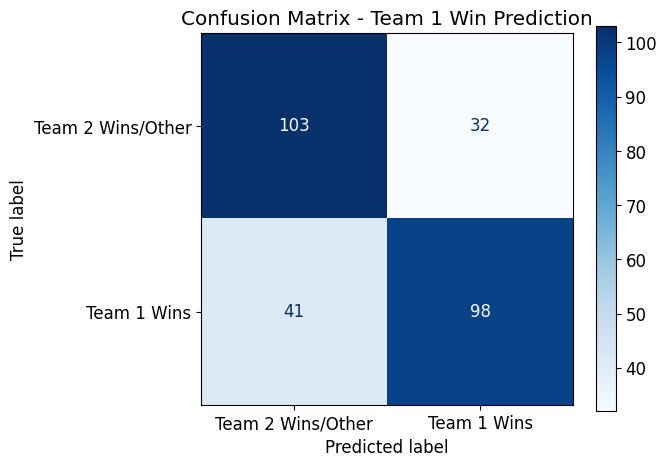

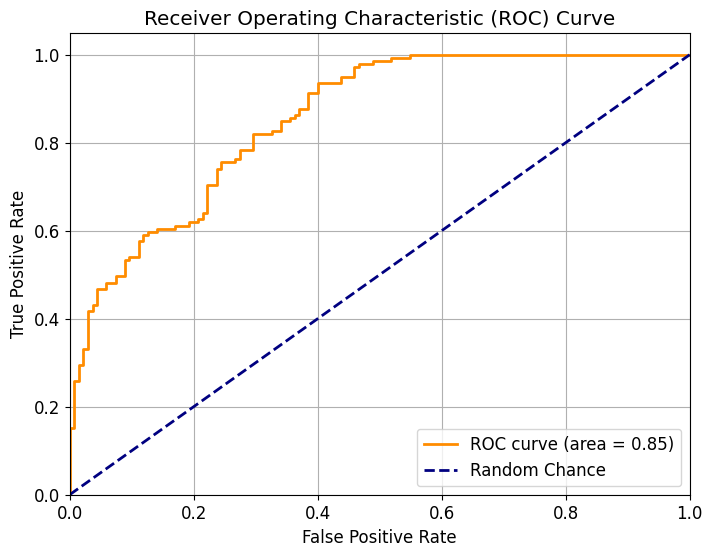


--- Feature Importance ---

Top 20 Features:
                                   feature  importance
1                              win_by_runs    0.215533
2                           win_by_wickets    0.200632
0                              season_year    0.157243
6                            is_team1_home    0.016355
59                     toss_decision_field    0.013945
34                    team2_Mumbai Indians    0.013459
5                               is_weekend    0.013400
42             toss_winner_Deccan Chargers    0.012130
7                            is_team2_home    0.010873
122  venue_MA Chidambaram Stadium, Chepauk    0.010599
153                    season_phase_Middle    0.009905
118            venue_M Chinnaswamy Stadium    0.009306
89                               city_Pune    0.008939
18                     team1_Pune Warriors    0.008786
29                    team2_Gujarat Titans    0.008559
49       toss_winner_Kolkata Knight Riders    0.008449
10                 

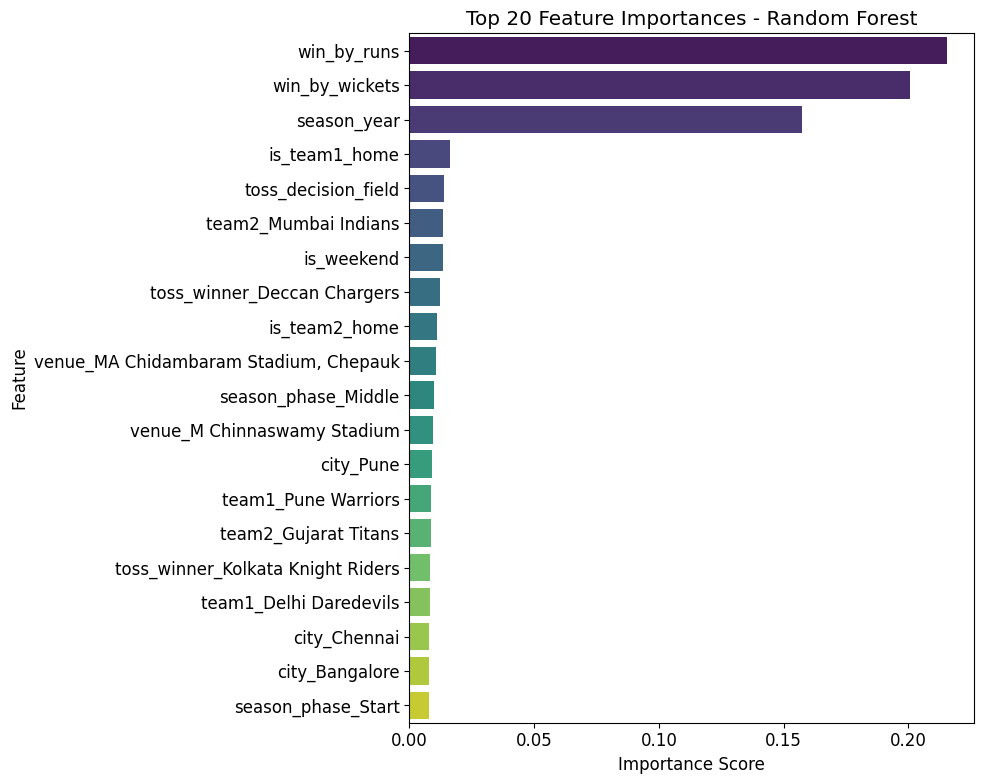

In [10]:
print("\n8.1 Classification Models (Training & Evaluating Random Forest for Team 1 Win)")

# Import necessary evaluation metrics
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, ConfusionMatrixDisplay)

# Check if training/testing data is available from step 6.3
if 'X_train' in locals() and X_train is not None and \
   'y_train' in locals() and y_train is not None and \
   'X_test' in locals() and X_test is not None and \
   'y_test' in locals() and y_test is not None:

    print(f"Using training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

    # --- Define the Model Pipeline ---
    # Pipeline helps ensure steps are applied consistently
    pipeline_rf = Pipeline([
        # Include scaling here if it wasn't applied universally to X before splitting
        # ('scaler', StandardScaler()), # Uncomment if X_train/X_test are not scaled yet
        ('classifier', RandomForestClassifier(
            random_state=42,
            n_estimators=150,          # Increased estimators slightly
            class_weight='balanced',   # Good for potentially imbalanced win rates
            max_depth=15,              # Limit tree depth to prevent overfitting
            min_samples_split=10,      # Minimum samples to split a node
            min_samples_leaf=5,        # Minimum samples at a leaf node
            n_jobs=-1                  # Use all available CPU cores
            ))
    ])

    # --- Train the Model ---
    print("\nTraining the Random Forest model...")
    try:
        pipeline_rf.fit(X_train, y_train)
        print("Model training completed.")

        # --- Make Predictions ---
        print("\nMaking predictions on the test set...")
        y_pred = pipeline_rf.predict(X_test)
        y_pred_proba = pipeline_rf.predict_proba(X_test)[:, 1] # Probability of Team 1 winning (class 1)
        print("Predictions generated.")

        # --- Evaluate the Model ---
        print("\n--- Model Evaluation ---")

        # 1. Accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")

        # 2. AUC-ROC Score
        try:
            auc_score = roc_auc_score(y_test, y_pred_proba)
            print(f"AUC-ROC Score: {auc_score:.4f}")
        except ValueError as e:
            print(f"Could not calculate AUC-ROC: {e}") # Handle cases with only one class in y_test

        # 3. Classification Report (Precision, Recall, F1-Score)
        print("\nClassification Report:")
        # Use target_names for better readability if desired
        print(classification_report(y_test, y_pred, target_names=['Team 2 Wins/Other', 'Team 1 Wins']))

        # 4. Confusion Matrix
        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_test, y_pred)
        # Plotting the Confusion Matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Team 2 Wins/Other', 'Team 1 Wins'])
        fig, ax = plt.subplots(figsize=(6, 5)) # Create figure and axes explicitly
        disp.plot(cmap='Blues', ax=ax) # Pass axes to display
        plt.title('Confusion Matrix - Team 1 Win Prediction')
        plt.show()


        # 5. ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

        # --- Feature Importance (for Random Forest) ---
        print("\n--- Feature Importance ---")
        # Access the classifier step in the pipeline
        if isinstance(pipeline_rf.named_steps['classifier'], RandomForestClassifier):
            classifier = pipeline_rf.named_steps['classifier']
            importances = classifier.feature_importances_
            feature_names = X_train.columns # Get feature names from training data

            # Create a DataFrame for better visualization
            feature_importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)

            # Display top N features
            n_top_features = 20
            print(f"\nTop {n_top_features} Features:")
            print(feature_importance_df.head(n_top_features))

            # Plot top N features
            plt.figure(figsize=(10, 8))
            sns.barplot(x='importance', y='feature', data=feature_importance_df.head(n_top_features), palette='viridis')
            plt.title(f'Top {n_top_features} Feature Importances - Random Forest')
            plt.xlabel('Importance Score')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.show()
        else:
            print("Could not extract feature importances (model is not a RandomForestClassifier or pipeline structure differs).")

    except Exception as e:
        print(f"\nAn error occurred during model training or evaluation: {e}")
        import traceback
        traceback.print_exc() # Print detailed traceback

else:
    print("\nSkipping Classification Model Training & Evaluation because training/testing data (X_train, y_train, X_test, y_test) is not available or not properly defined.")

# 8.2 Regression Model


8.2 Regression Models (Training & Evaluating GBR for Run Margin)

Preparing data for run margin prediction...
Found 498 matches won by runs.
Shape of feature set for regression (X_reg): (498, 154)
Shape of target set for regression (y_reg): (498,)

Regression data split:
Training set shape: X=(373, 154), y=(373,)
Test set shape: X=(125, 154), y=(125,)

Training the Gradient Boosting Regressor model...
Model training completed.

Making predictions on the test set...
Predictions generated.

--- Regression Model Evaluation ---
Mean Absolute Error (MAE): 20.31 runs
Root Mean Squared Error (RMSE): 27.30 runs
R-squared (R²): -0.0803


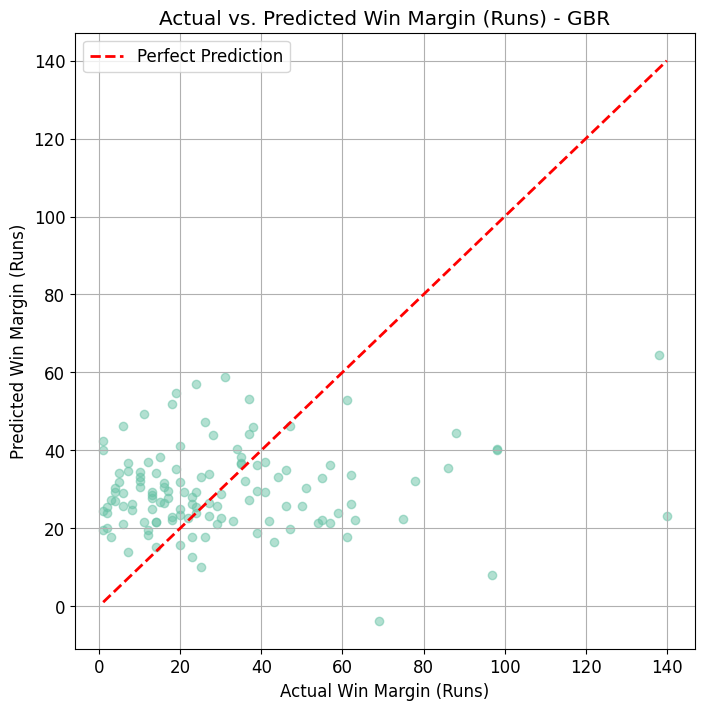


--- Feature Importance (GBR) ---

Top 20 Features:
                                               feature  importance
0                                          season_year    0.209443
153                                 season_phase_Start    0.077180
3                                           is_weekend    0.040047
94                                  city_Visakhapatnam    0.032659
58                                 toss_decision_field    0.032299
5                                        is_team1_home    0.031818
25                                team2_Delhi Capitals    0.031554
76                                         city_Jaipur    0.025916
4                                toss_winner_won_match    0.025828
152                                season_phase_Middle    0.025421
29                               team2_Kings XI Punjab    0.023068
60                                      city_Bangalore    0.022507
43                        toss_winner_Delhi Daredevils    0.021827
69        

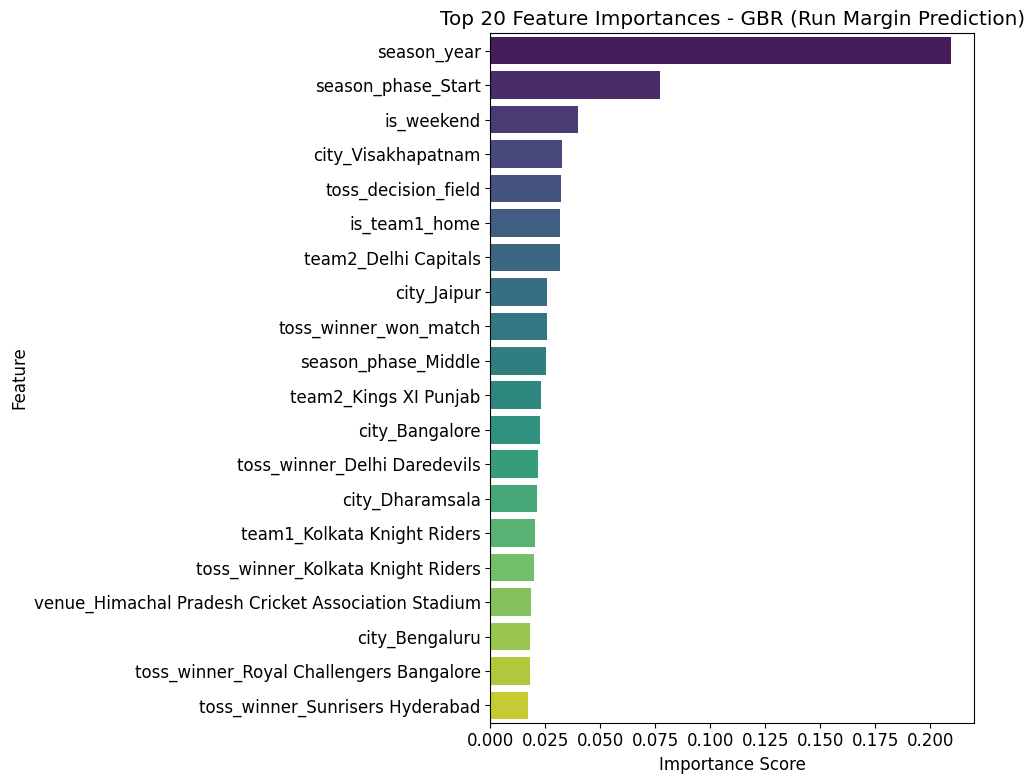

In [11]:
# --- 8.2 Regression Models ---
print("\n8.2 Regression Models (Training & Evaluating GBR for Run Margin)")

# Import necessary evaluation metrics for regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler # Ensure scaler is imported if needed in pipeline

# --- Data Preparation for Regression ---
print("\nPreparing data for run margin prediction...")

# Define the target population: Matches won by runs
# Ensure 'matches_clean' and 'model_df_encoded' are available
if 'matches_clean' in locals() and 'model_df_encoded' in locals():
    reg_target_df = matches_clean[matches_clean['win_by_runs'] > 0].copy()

    if not reg_target_df.empty:
        print(f"Found {len(reg_target_df)} matches won by runs.")
        # Align features from model_df_encoded with this subset using index
        # Ensure model_df_encoded has been created in step 6.1
        if reg_target_df.index.isin(model_df_encoded.index).all():
            X_reg_all = model_df_encoded.loc[reg_target_df.index].copy()

            # Define target variable
            y_reg = reg_target_df['win_by_runs']

            # Define features: Drop target and other potential leakage columns
            features_to_drop = ['win_by_runs', 'win_by_wickets'] # Always drop target and other margin
            # Optionally drop others if they leak info strongly for this specific task
            # features_to_drop.append('toss_winner_won_match')

            cols_exist_to_drop = [col for col in features_to_drop if col in X_reg_all.columns]
            X_reg = X_reg_all.drop(columns=cols_exist_to_drop)
            print(f"Shape of feature set for regression (X_reg): {X_reg.shape}")
            print(f"Shape of target set for regression (y_reg): {y_reg.shape}")

            # Check alignment one last time
            if len(X_reg) == len(y_reg):
                # --- Train-Test Split for Regression Data ---
                X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
                    X_reg, y_reg, test_size=0.25, random_state=42
                )
                print(f"\nRegression data split:")
                print(f"Training set shape: X={X_reg_train.shape}, y={y_reg_train.shape}")
                print(f"Test set shape: X={X_reg_test.shape}, y={y_reg_test.shape}")

                # --- Define the Model Pipeline (with Scaling) ---
                pipeline_gbr = Pipeline([
                    ('scaler', StandardScaler()), # Scaling is generally important for GBR
                    ('regressor', GradientBoostingRegressor(
                        random_state=42,
                        n_estimators=100,         # Number of boosting stages
                        learning_rate=0.1,        # Step size shrinkage
                        max_depth=5,              # Limit tree depth
                        min_samples_split=10,     # Min samples to split
                        min_samples_leaf=5,       # Min samples per leaf
                        loss='squared_error'      # Default loss function for regression
                    ))
                ])

                # --- Train the Model ---
                print("\nTraining the Gradient Boosting Regressor model...")
                try:
                    pipeline_gbr.fit(X_reg_train, y_reg_train)
                    print("Model training completed.")

                    # --- Make Predictions ---
                    print("\nMaking predictions on the test set...")
                    y_reg_pred = pipeline_gbr.predict(X_reg_test)
                    print("Predictions generated.")

                    # --- Evaluate the Model ---
                    print("\n--- Regression Model Evaluation ---")

                    # 1. Mean Absolute Error (MAE)
                    mae = mean_absolute_error(y_reg_test, y_reg_pred)
                    print(f"Mean Absolute Error (MAE): {mae:.2f} runs")

                    # 2. Root Mean Squared Error (RMSE)
                    rmse = mean_squared_error(y_reg_test, y_reg_pred, squared=False)
                    print(f"Root Mean Squared Error (RMSE): {rmse:.2f} runs")

                    # 3. R-squared (R²) Score
                    r2 = r2_score(y_reg_test, y_reg_pred)
                    print(f"R-squared (R²): {r2:.4f}")

                    # 4. Scatter Plot: Actual vs Predicted
                    plt.figure(figsize=(8, 8))
                    plt.scatter(y_reg_test, y_reg_pred, alpha=0.5)
                    plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], '--r', lw=2, label='Perfect Prediction')
                    plt.xlabel("Actual Win Margin (Runs)")
                    plt.ylabel("Predicted Win Margin (Runs)")
                    plt.title("Actual vs. Predicted Win Margin (Runs) - GBR")
                    plt.legend()
                    plt.grid(True)
                    plt.show()

                    # --- Feature Importance (for Gradient Boosting) ---
                    print("\n--- Feature Importance (GBR) ---")
                    # Access the regressor step in the pipeline
                    if isinstance(pipeline_gbr.named_steps['regressor'], GradientBoostingRegressor):
                        regressor = pipeline_gbr.named_steps['regressor']
                        importances = regressor.feature_importances_
                        feature_names = X_reg_train.columns # Get feature names from training data

                        # Create a DataFrame
                        feature_importance_df_reg = pd.DataFrame({
                            'feature': feature_names,
                            'importance': importances
                        }).sort_values('importance', ascending=False)

                        # Display top N features
                        n_top_features = 20
                        print(f"\nTop {n_top_features} Features:")
                        print(feature_importance_df_reg.head(n_top_features))

                        # Plot top N features
                        plt.figure(figsize=(10, 8))
                        sns.barplot(x='importance', y='feature', data=feature_importance_df_reg.head(n_top_features), palette='viridis')
                        plt.title(f'Top {n_top_features} Feature Importances - GBR (Run Margin Prediction)')
                        plt.xlabel('Importance Score')
                        plt.ylabel('Feature')
                        plt.tight_layout()
                        plt.show()
                    else:
                        print("Could not extract feature importances (model is not GradientBoostingRegressor or pipeline structure differs).")

                except Exception as e:
                    print(f"\nAn error occurred during regression model training or evaluation: {e}")
                    import traceback
                    traceback.print_exc() # Print detailed traceback

            else:
                print("\nSkipping Regression: Feature and target data lengths do not match after alignment.")
        else:
            print("\nSkipping Regression: Index mismatch between target data and encoded features.")
    else:
        print("\nSkipping Regression: No matches found meeting the criteria (win_by_runs > 0).")
else:
    print("\nSkipping Regression Model Training & Evaluation because base dataframes ('matches_clean' or 'model_df_encoded') are not available.")

# 8.3 Time Series Analysis (Runs per Over and Seasonal Trends)

In [12]:
# --- 8.3 Time Series Analysis ---
print("\n8.3 Time Series Analysis (Runs per Over and Seasonal Trends)")

# Ensure 'deliveries_merged' is available from Section 4b
if 'deliveries_merged' in locals() and not deliveries_merged.empty:

    # --- Analysis 1: Average Runs per Over (Overall and by Innings) ---
    print("\nAnalyzing average runs per over...")
    # Group by match, inning, and over to get total runs in that specific over
    runs_per_over_inning = deliveries_merged.groupby(['match_id', 'inning', 'over'])['total_runs'].sum().reset_index()

    # Calculate overall average runs for each over number (0-19)
    avg_runs_per_over_overall = runs_per_over_inning.groupby('over')['total_runs'].mean()

    # Calculate average runs separately for first and second innings
    avg_runs_per_over_inning1 = runs_per_over_inning[runs_per_over_inning['inning'] == 1].groupby('over')['total_runs'].mean()
    avg_runs_per_over_inning2 = runs_per_over_inning[runs_per_over_inning['inning'] == 2].groupby('over')['total_runs'].mean()

    # Create a combined plot
    fig_ts_innings = go.Figure()

    # Add Overall Trace
    if not avg_runs_per_over_overall.empty:
        fig_ts_innings.add_trace(go.Scatter(
            x=avg_runs_per_over_overall.index,
            y=avg_runs_per_over_overall.values,
            mode='lines+markers', name='Overall Average', line=dict(color='grey', dash='dash')
        ))

    # Add Inning 1 Trace
    if not avg_runs_per_over_inning1.empty:
        fig_ts_innings.add_trace(go.Scatter(
            x=avg_runs_per_over_inning1.index,
            y=avg_runs_per_over_inning1.values,
            mode='lines+markers', name='Inning 1 Average', line=dict(color='royalblue')
        ))

    # Add Inning 2 Trace
    if not avg_runs_per_over_inning2.empty:
        fig_ts_innings.add_trace(go.Scatter(
            x=avg_runs_per_over_inning2.index,
            y=avg_runs_per_over_inning2.values,
            mode='lines+markers', name='Inning 2 Average', line=dict(color='firebrick')
        ))

    # Update layout for clarity
    fig_ts_innings.update_layout(
        title='Average Runs Scored per Over (Overall vs. Innings)',
        xaxis_title='Over Number (0-indexed)',
        yaxis_title='Average Runs Scored',
        xaxis=dict(tickmode='linear'), # Ensure x-axis treats over number numerically
        legend_title_text='Metric'
    )
    fig_ts_innings.show()


    # --- Analysis 2: Trend of Runs in Key Phases Over Seasons ---
    # Requires 'season_year' from the merge
    if 'season_year' in deliveries_merged.columns:
        print("\nAnalyzing run rate trends in key phases over seasons...")

        # Define phases (example: Powerplay 0-5, Middle 6-14, Death 15-19)
        deliveries_merged['phase'] = pd.cut(
            deliveries_merged['over'],
            bins=[-1, 5, 14, 19],          # Bins: (-1, 5], (5, 14], (14, 19]
            labels=['Powerplay', 'Middle', 'Death']
        )

        # Calculate average runs per ball (run rate) in each phase per season
        # Group by season, phase, and inning first
        phase_data = deliveries_merged.groupby(['season_year', 'phase', 'inning'])['total_runs'].agg(['sum', 'count']).reset_index()
        # Calculate runs per ball (count includes all deliveries in that phase)
        phase_data['runs_per_ball'] = phase_data['sum'] / phase_data['count']
        phase_data['run_rate_per_over'] = phase_data['runs_per_ball'] * 6 # Approximate run rate

        # Plot the trend for each phase (separating innings)
        fig_phase_trend = px.line(
            phase_data.sort_values(['season_year', 'inning', 'phase']),
            x='season_year',
            y='run_rate_per_over',
            color='phase',          # Color lines by phase
            line_dash='inning',     # Dash lines by inning (requires inning as string/category)
            markers=True,
            facet_col='inning',     # Optional: Separate plots for each inning
            labels={'season_year': 'Season', 'run_rate_per_over': 'Approx Run Rate per Over', 'phase':'Phase', 'inning':'Inning'},
            title='Run Rate Trend in Different Phases Over Seasons (by Inning)'
        )
        fig_phase_trend.update_layout(xaxis={'type': 'category'}) # Treat year as category
        fig_phase_trend.for_each_annotation(lambda a: a.update(text=f"Inning {a.text.split('=')[-1]}")) # Clean up facet titles
        fig_phase_trend.show()

    else:
        print("\nSkipping seasonal trend analysis as 'season_year' is not available in deliveries data.")

else:
    print("\nSkipping Time Series Analysis as 'deliveries_merged' data is not available.")


8.3 Time Series Analysis (Runs per Over and Seasonal Trends)

Analyzing average runs per over...



Analyzing run rate trends in key phases over seasons...


# 9. Visualisations for Dashboard


---------- 9. VISUALIZATIONS FOR Dashboard ----------
Generating selected presentation-ready visualizations...


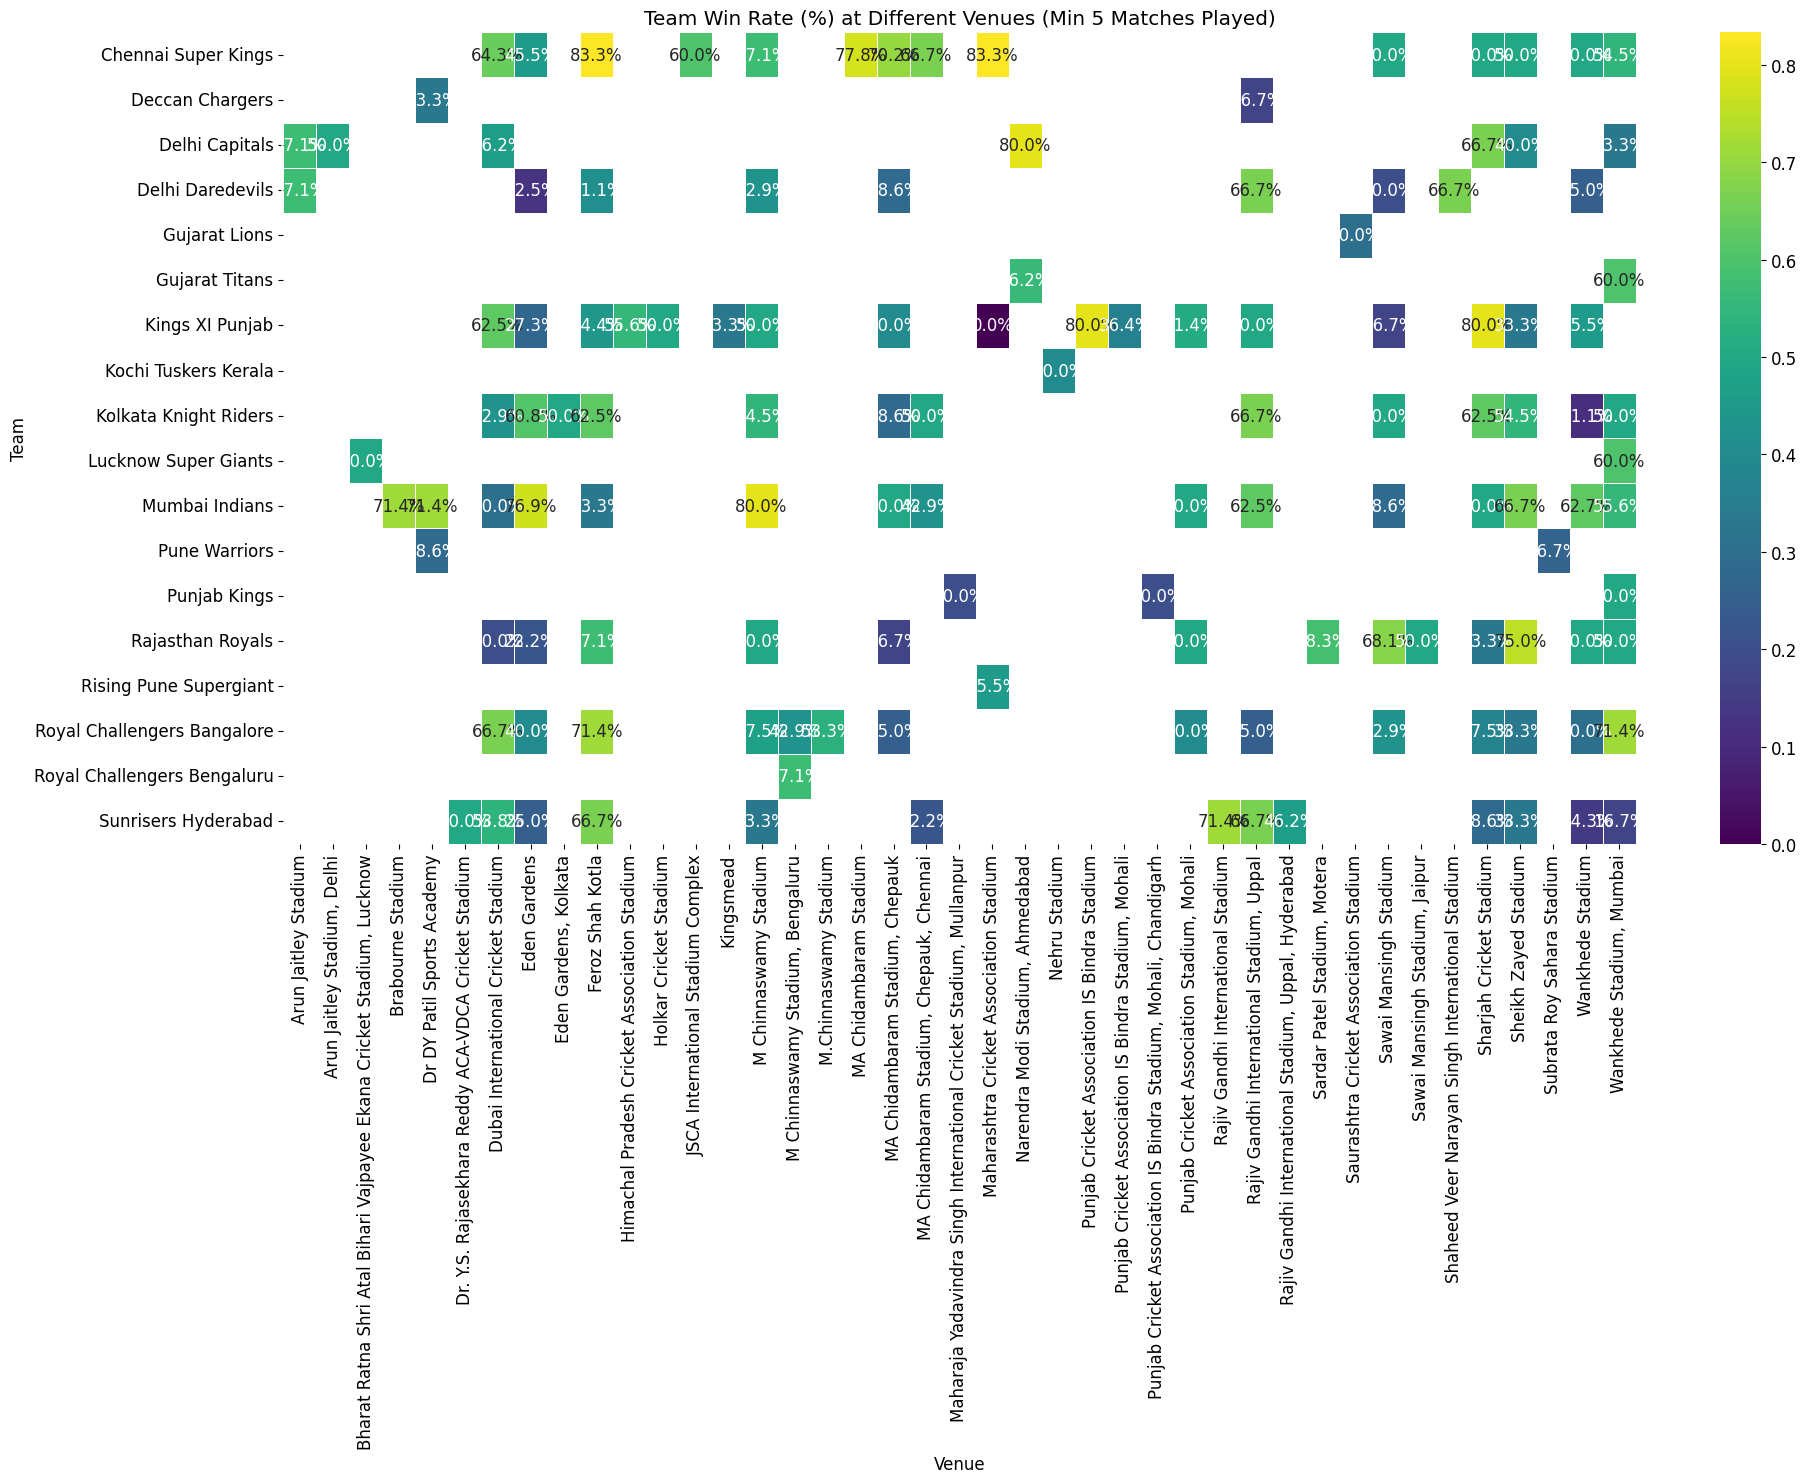

In [13]:
print("\n---------- 9. VISUALIZATIONS FOR Dashboard ----------")
print("Generating selected presentation-ready visualizations...")

# 9.1 Interactive Batsman Comparison (Example: Runs vs Strike Rate)
batsman_stats = pd.DataFrame({
    'runs': batsman_runs,
    'balls': balls_faced,
    'strike_rate': batsman_strike_rate,
    'average': batsman_average,
    'dismissals': dismissals
}).dropna(subset=['strike_rate', 'average']) # Drop if SR or Avg couldn't be calculated

# Filter for plotting (e.g., min 500 runs)
batsman_stats_filtered = batsman_stats[batsman_stats['runs'] >= 1000].reset_index()

fig_scatter = px.scatter(batsman_stats_filtered, x='strike_rate', y='average',
                         size='runs', color='runs', hover_name='batter',
                         title='Batsman Performance Comparison (Average vs Strike Rate, Size=Runs, Min 1000 Runs)',
                         labels={'strike_rate': 'Strike Rate', 'average': 'Average Runs per Dismissal', 'runs': 'Total Runs'},
                         color_continuous_scale=px.colors.sequential.Viridis)
fig_scatter.update_layout(xaxis_title="Strike Rate", yaxis_title="Average")
fig_scatter.show()

# Example Placeholder: Heatmap of Team vs Venue Win Rates
venue_pivot = venue_performance[venue_performance['matches'] >= 5].pivot(index='team', columns='venue', values='win_rate')
plt.figure(figsize=(20, 15))
sns.heatmap(venue_pivot, annot=True, fmt=".1%", cmap="viridis", linewidths=.5)
plt.title('Team Win Rate (%) at Different Venues (Min 5 Matches Played)')
plt.xlabel('Venue')
plt.ylabel('Team')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 10. Summary of Analysis


---------- 10. SUMMARY OF ANALYSIS ----------

Key insights from the analysis using matches.csv and deliveries.csv:
1.  Data Cleaning: Successfully adapted cleaning steps for the new datasets, handling missing values and deriving essential columns like 'win_by_runs'/'win_by_wickets'. Standardized team names.
2.  EDA (Matches): Analyzed seasonal trends, team dominance, toss impact, venue preferences, and player awards based on the match-level data.
3.  EDA (Deliveries): Performed detailed batsman analysis, identifying top run-scorers, best strike rates, highest averages, and most sixes overall and per season.
4.  Feature Engineering: Created matchup features, team win rates, simplified home advantage, and seasonal phase indicators from match data. Explored Elo ratings.
5.  Modeling Prep: Prepared data for modeling by encoding categorical features and scaling numerical ones, demonstrating setup for classification and regression tasks.
6.  Visualization: Utilized Plotly for interactive v

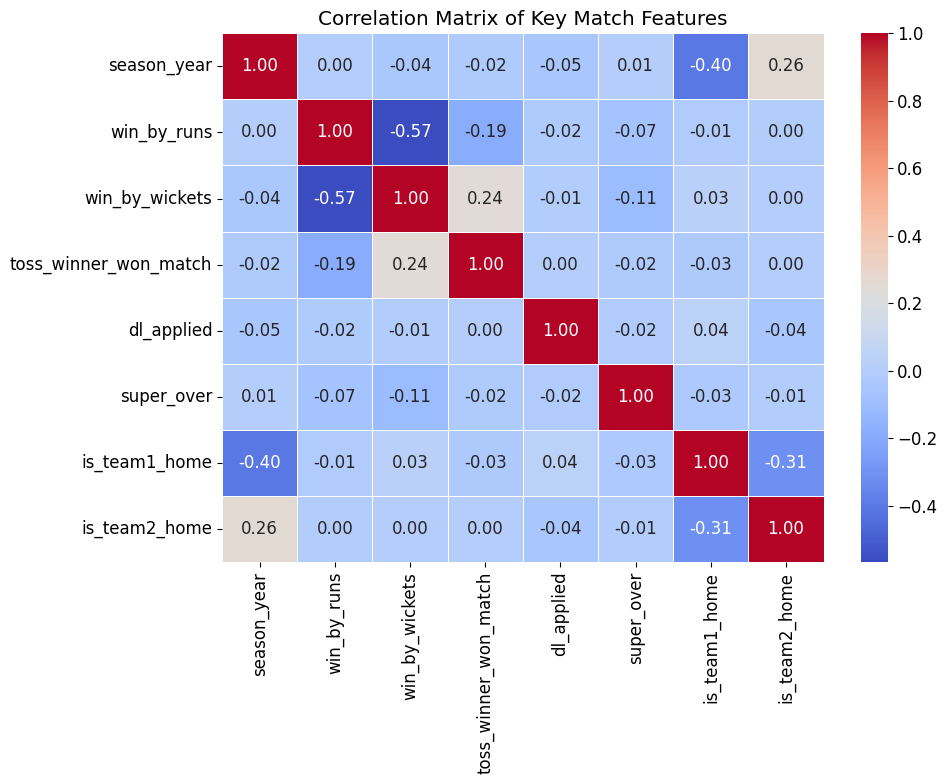


End of IPL Data Analysis


In [14]:
# --- 10. SUMMARY OF ANALYSIS ---
print("\n---------- 10. SUMMARY OF ANALYSIS ----------")
print("""
Key insights from the analysis using matches.csv and deliveries.csv:
1.  Data Cleaning: Successfully adapted cleaning steps for the new datasets, handling missing values and deriving essential columns like 'win_by_runs'/'win_by_wickets'. Standardized team names.
2.  EDA (Matches): Analyzed seasonal trends, team dominance, toss impact, venue preferences, and player awards based on the match-level data.
3.  EDA (Deliveries): Performed detailed batsman analysis, identifying top run-scorers, best strike rates, highest averages, and most sixes overall and per season.
4.  Feature Engineering: Created matchup features, team win rates, simplified home advantage, and seasonal phase indicators from match data. Explored Elo ratings.
5.  Modeling Prep: Prepared data for modeling by encoding categorical features and scaling numerical ones, demonstrating setup for classification and regression tasks.
6.  Visualization: Utilized Plotly for interactive visualizations of match trends, team performance, venue stats, and detailed batsman statistics (runs, SR, Avg, Sixes).

This analysis provides a more comprehensive view by combining match outcomes with ball-by-ball details, enabling deeper player performance insights alongside match-level trends.
""")

# --- 11. APPLIED STATISTICS ---
print("\n---------- 11. APPLIED STATISTICS ----------")

# 11.1 Hypothesis Testing (Toss Advantage - Rerun on cleaned data)
print("\n11.1 Hypothesis Testing (Toss Advantage)")
from scipy import stats

# Use the previously calculated 'valid_matches_for_toss_impact' which excludes 'No Result' etc.
toss_winner_won = valid_matches_for_toss_impact['toss_winner_won_match']
observed_p = toss_winner_won.mean()
n_trials = len(toss_winner_won)
n_successes = toss_winner_won.sum()

if n_trials > 0:
    result = stats.binomtest(n_successes, n_trials, p=0.5, alternative='greater') # Test if significantly > 50%
    print(f"Observed proportion of toss winners winning the match: {observed_p:.4f}")
    print(f"Binomial test p-value (one-sided, > 0.5): {result.pvalue:.4f}")
    if result.pvalue < 0.05:
        print("Reject null hypothesis: Winning the toss provides a statistically significant advantage.")
    else:
        print("Fail to reject null hypothesis: No significant evidence that winning the toss provides an advantage (p >= 0.05).")
else:
    print("Not enough valid matches to perform hypothesis test.")


# 11.2 Statistical Correlations (Matches Data)
print("\n11.2 Statistical Correlations")
# Select a subset of numerical/binary features from matches_clean
correlation_features = ['season_year', 'win_by_runs', 'win_by_wickets',
                        'toss_winner_won_match', 'dl_applied', 'super_over',
                        'is_team1_home', 'is_team2_home']
# Ensure columns exist before calculating correlation
valid_corr_features = [col for col in correlation_features if col in matches_clean.columns]
correlation_matrix = matches_clean[valid_corr_features].corr()

print("Correlation matrix (Matches Data):")
print(correlation_matrix)

# Visualize Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Key Match Features')
plt.tight_layout()
plt.show()


print("\nEnd of IPL Data Analysis")